In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses, Input
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np
import sys
from PIL import Image
import joblib
import pandas as pd
sys.path.append('../')

from utils.tensorflow_preprocessing import prepare_image_dataset, process_image_for_model

In [2]:
FEATURE_VEC_DIM = 16

In [3]:
# Basic Model Training
def create_feature_extraction():
    model = models.Sequential([
        Input(shape=(256, 256, 3)),
        layers.Conv2D(32, (4, 4), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (4, 4), activation='relu'),
        layers.AveragePooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(FEATURE_VEC_DIM),
    ])

    model.compile(optimizer='adam', loss='mse')

    return model


In [4]:
feature_extraction = create_feature_extraction()
feature_extraction.save('../data/models/fe-cnn', overwrite=True)




INFO:tensorflow:Assets written to: ../data/models/fe-cnn\assets


INFO:tensorflow:Assets written to: ../data/models/fe-cnn\assets


In [5]:
rec_df = pd.read_csv('../data/recommend/csv/rec_df.csv')
rec_df.shape

(84796, 8)

In [7]:
recommendations = {'Path': [], 'Class': [], 'Style': []}
for j in range(FEATURE_VEC_DIM):
    recommendations[f'x{j}'] = []

In [8]:
for i, row in rec_df.iterrows():
    recommendations['Path'].append(row['Path'])
    recommendations['Class'].append(row['Class'])
    recommendations['Style'].append(row['Style'])
    ref_processed = process_image_for_model('../data/raw/Furniture_Data/' + row['Path'], 256, 256)

    ref_feature_vector = feature_extraction.predict(ref_processed, verbose=0)
    for j, feature in enumerate(ref_feature_vector.reshape(-1)):
        recommendations[f'x{j}'].append(feature)

In [9]:
recommendations_df = pd.DataFrame(recommendations)
recommendations_df.to_csv('../data/recommend/csv/recommendations.csv', index=False)

In [10]:
cluster = KMeans(init='k-means++', n_init='auto')

In [11]:
joblib.dump(cluster, '../data/models/cluster-kmeans.model')

['../data/models/cluster-kmeans.model']

# Run from here

In [12]:
df_raw = pd.read_csv('../data/processed/csv/df.csv')
df_sample_ref_img_paths = df_raw.sample(4, random_state=21)['Path']

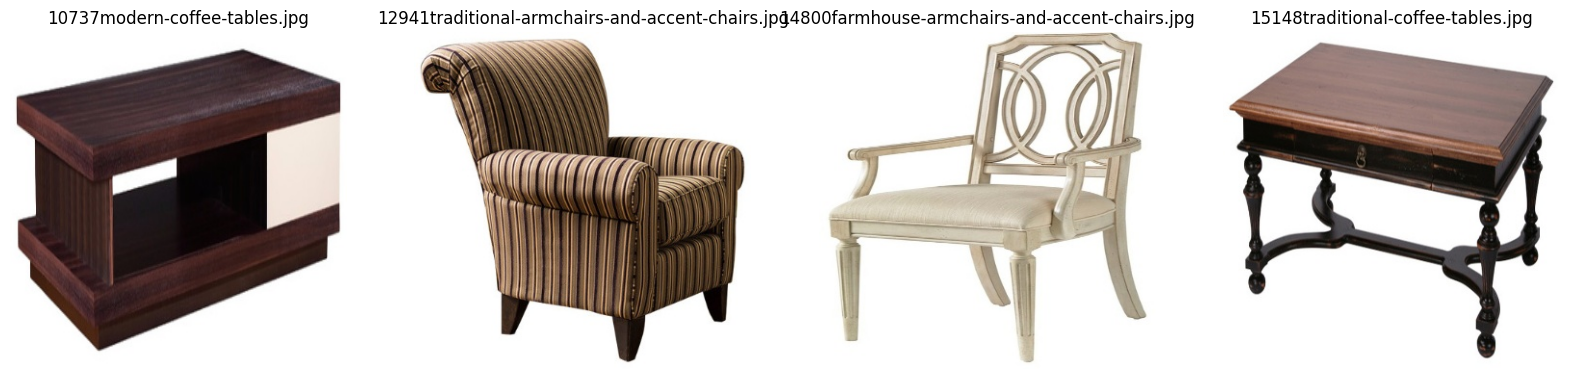

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, ref_path in enumerate(df_sample_ref_img_paths):
    with Image.open('../data/raw/Furniture_Data/' + f'{ref_path}') as ref:
        ax[i].imshow(ref)
        ax[i].set_title(ref_path.split('/')[-1], fontsize=12)
        ax[i].axis('off')

plt.show()

In [14]:
feature_extraction = models.load_model('../data/models/fe-cnn')
cluster = joblib.load('../data/models/cluster-kmeans.model')

In [15]:
num_recommendations = 4   # Number of recommendations per reference image (testing)
k = int(np.sqrt(len(rec_df) / num_recommendations))
cluster.set_params(n_clusters=k)

KMeans(n_clusters=145)

In [ ]:
class_encoder = LabelEncoder()
encoder_path = '../data/label_encoders'
class_encoder.classes_ = np.load(encoder_path + "/" + 'class_encoder.npy', allow_pickle=True)

In [16]:
def classify(image_path: str, classifier_path: str):

    image = process_image_for_model(image_path, 256, 256)

    model = models.load_model(classifier_path)
    pred = model.predict(image)

    pred_class_idx = tf.argmax(pred, axis=1).numpy()[0]
    
    predicted_label = class_encoder.inverse_transform([pred_class_idx])[0]

    print(predicted_label)
    
    return image, predicted_label

In [17]:
recommendations_df = pd.read_csv('../data/recommend/csv/recommendations.csv')

In [21]:

results = []
for ref_path in df_sample_ref_img_paths:
    image, pred_class_label = classify('../data/raw/Furniture_Data/' + f'{ref_path}', '../data/models/task-1-CNN.keras')

    image = np.squeeze(image)  

    ref_feature_vector = feature_extraction.predict(
            tf.expand_dims(image, axis=0),
            verbose=0
        )
        
    ref_feature_vector = ref_feature_vector.astype(np.float64)
    ref_feature_vector = ref_feature_vector.reshape(1, -1)

    # Filter recommendations based on predicted class
    filtered_recommendations = recommendations_df[recommendations_df['Class'] == pred_class_label]

    # Cluster reference image
    cluster.fit(filtered_recommendations.drop(['Path', 'Class', 'Style'], axis='columns').values)
    ref_cluster = cluster.predict(ref_feature_vector)
    ref_cluster_indices = np.where(cluster.labels_ == ref_cluster)[0]
    recommendations = filtered_recommendations.iloc[ref_cluster_indices]

    # Calculate cosine similarities
    cosine_similarities = cosine_similarity(ref_feature_vector, recommendations.drop(['Path', 'Class', 'Style'], axis='columns'))
    sorted_ref_cluster_indices = np.argsort(-cosine_similarities.flatten())
    top_ref_cluster_indices = sorted_ref_cluster_indices[:num_recommendations]
    top_recommendations = recommendations.iloc[top_ref_cluster_indices]

    results.append(top_recommendations['Path'].values)

print(results)

1/1 [==============================] - 0s 165ms/step
tables
1/1 [==============================] - 0s 165ms/step
chairs
1/1 [==============================] - 0s 189ms/step
chairs
1/1 [==============================] - 0s 193ms/step
tables
[array(['tables/Modern/10737modern-coffee-tables.jpg',
       'tables/Traditional/14265traditional-coffee-tables.jpg',
       'tables/Industrial/35300industrial-coffee-tables.jpg',
       'tables/Contemporary/2696contemporary-coffee-tables.jpg'],
      dtype=object), array(['chairs/Traditional/12941traditional-armchairs-and-accent-chairs.jpg',
       'chairs/Contemporary/1950contemporary-folding-chairs-and-stools.jpg',
       'chairs/Industrial/38646industrial-dining-chairs.jpg',
       'chairs/Contemporary/4758contemporary-dining-chairs.jpg'],
      dtype=object), array(['chairs/Farmhouse/34384farmhouse-armchairs-and-accent-chairs.jpg',
       'chairs/Farmhouse/14800farmhouse-armchairs-and-accent-chairs.jpg',
       'chairs/Traditional/10416traditio

1/1 [==============================] - 0s 211ms/step
tables
1/1 [==============================] - 0s 148ms/step
chairs
1/1 [==============================] - 0s 185ms/step
chairs
1/1 [==============================] - 0s 170ms/step
tables


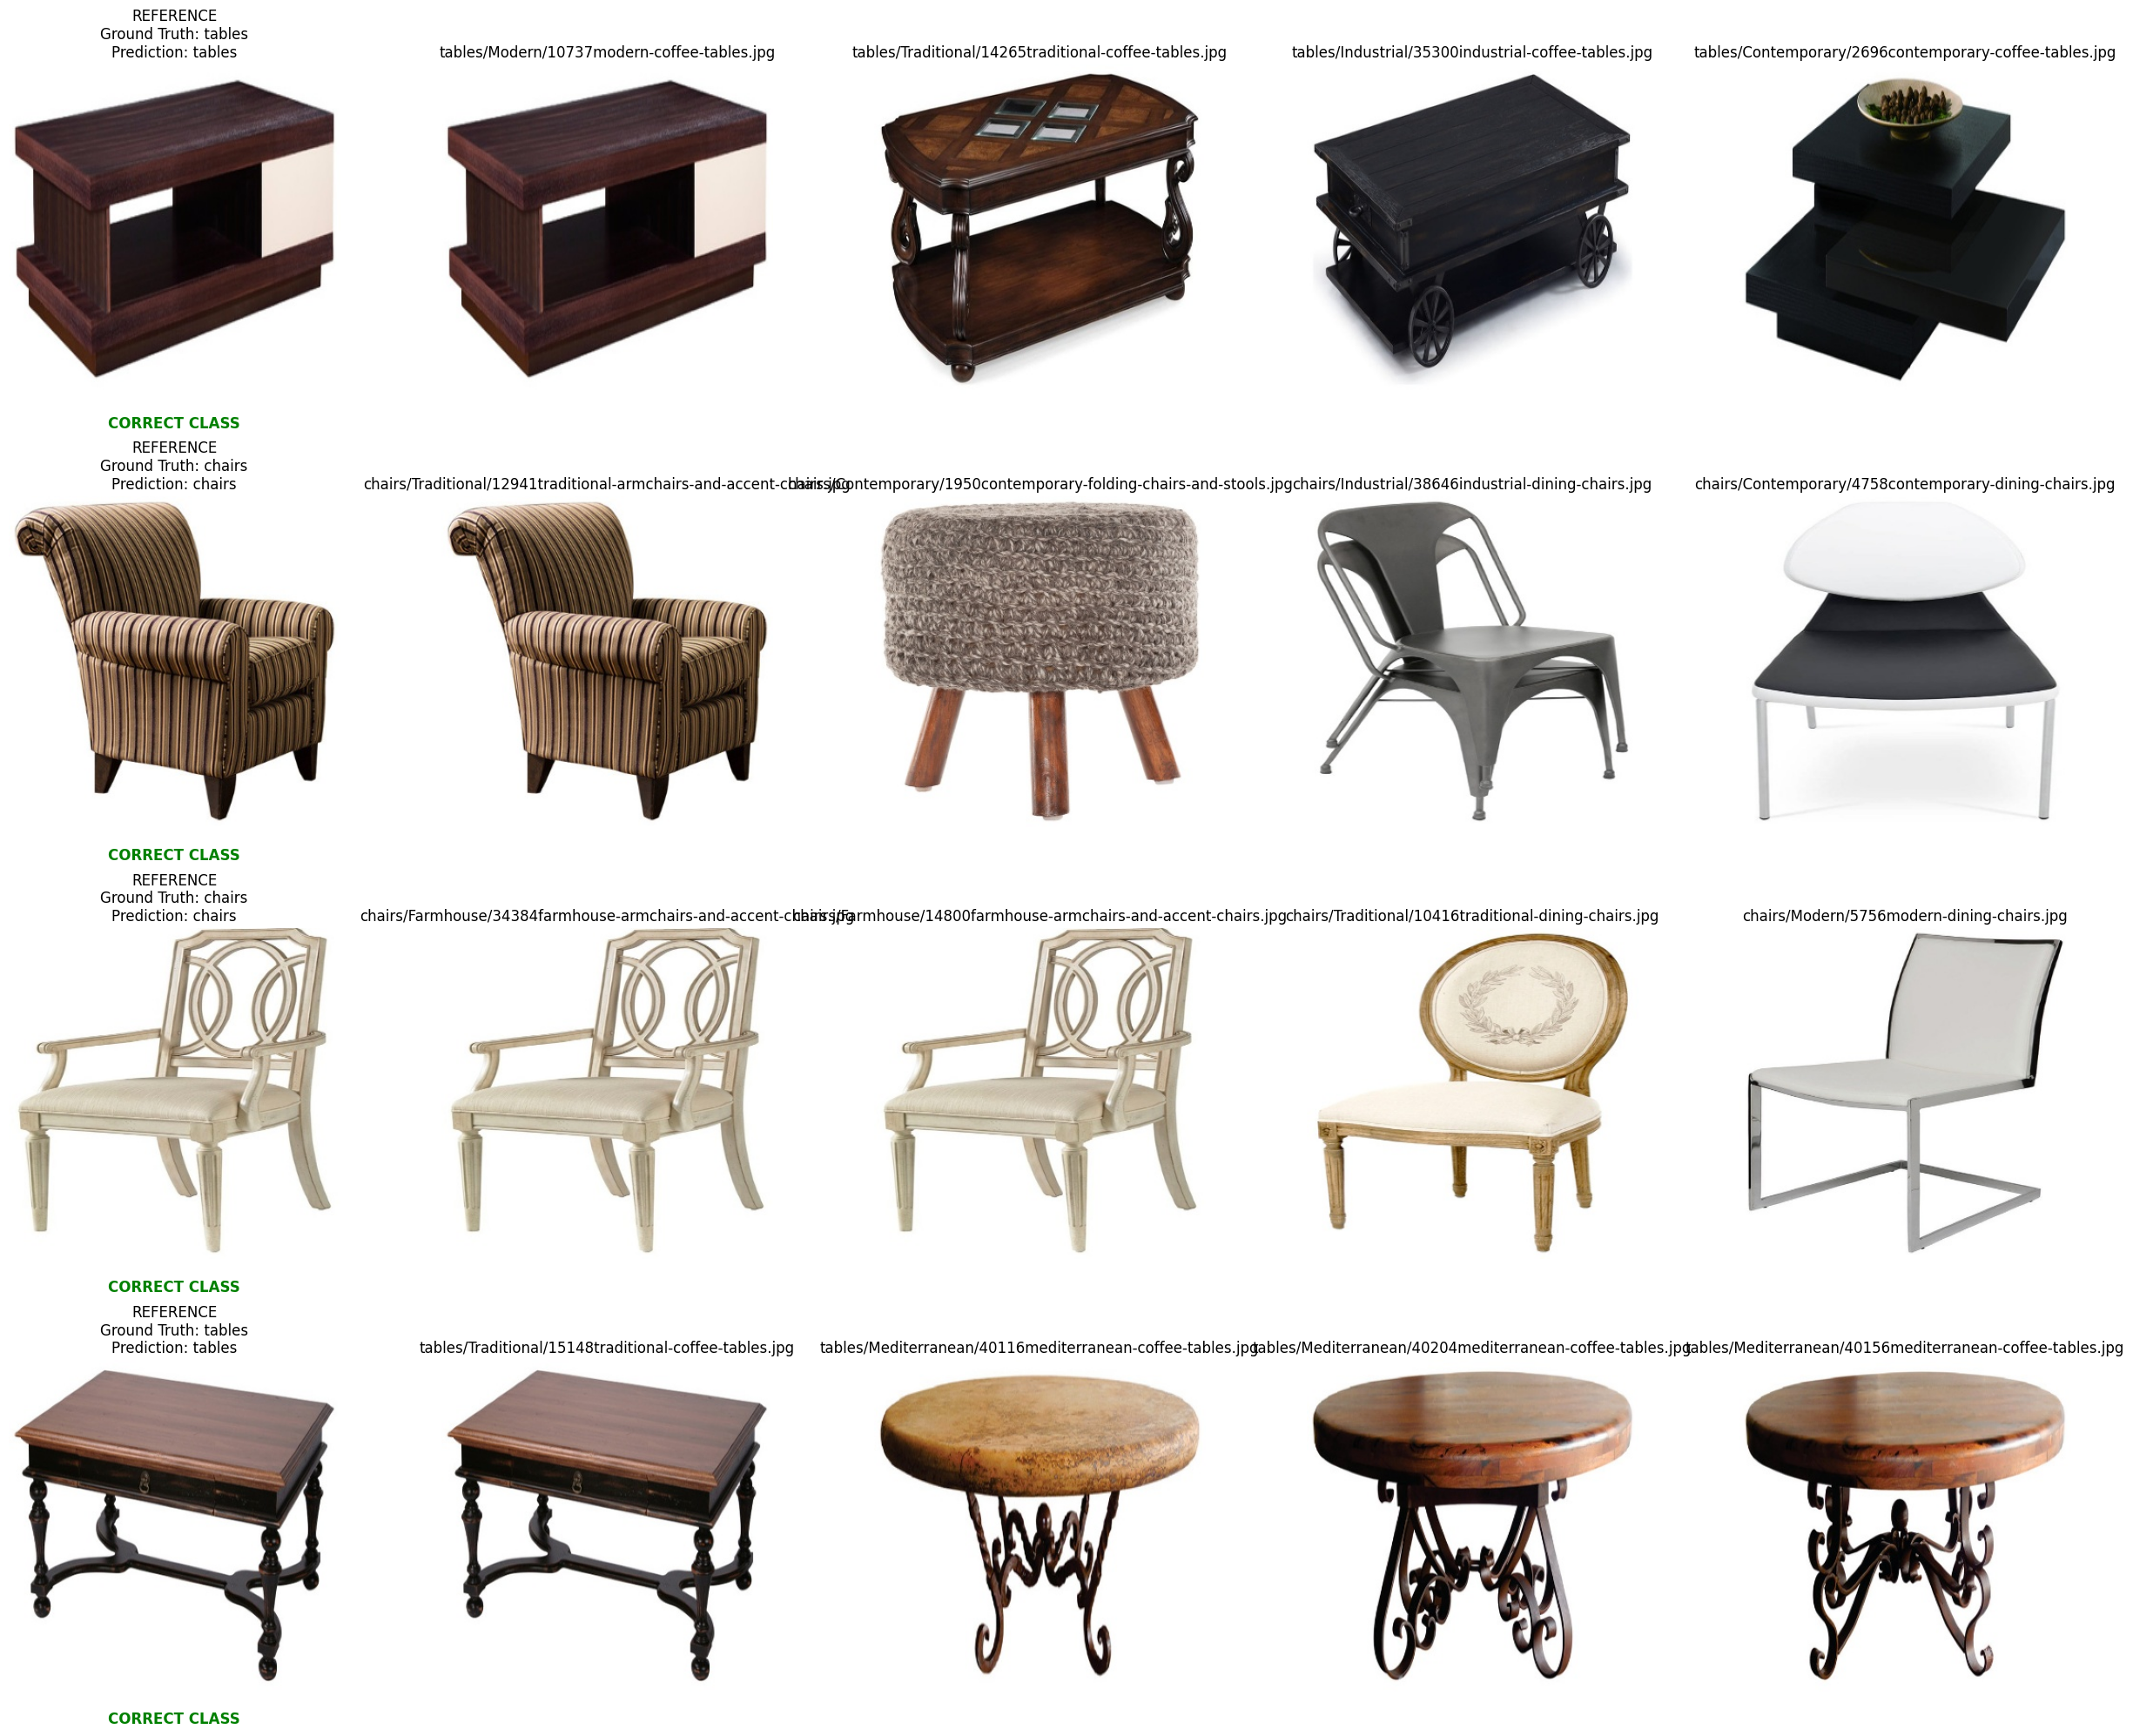

In [22]:
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
for i, ref_path in enumerate(df_sample_ref_img_paths):
    with Image.open('../data/raw/Furniture_Data/' + f'{ref_path}') as ref:
        true_label = ref_path.split('/')[0]
        _, predicted_label = classify('../data/raw/Furniture_Data/' + f'{ref_path}', classifier_path='../data/models/task-1-CNN.keras')

        ax[i][0].imshow(ref)
        ax[i][0].set_title(
            f'REFERENCE\n'
            f'Ground Truth: {true_label}\n'
            f'Prediction: {predicted_label}',
            fontsize=12
        )
        ax[i][0].text(
            0.5, -0.08, f'{"CORRECT CLASS" if true_label == predicted_label else "INCORRECT CLASS"}',
            horizontalalignment='center',
            verticalalignment='center_baseline',
            transform=ax[i][0].transAxes,
            fontsize=12,
            color='green' if true_label == predicted_label else 'red',
            weight='bold'
        )
        ax[i][0].axis('off')

    for j, rec_path in enumerate(results[i], start=1):
        with Image.open('../data/raw/Furniture_Data/' + f'{rec_path}') as rec:
            ax[i][j].imshow(rec)
            ax[i][j].set_title(rec_path, fontsize=12)
            ax[i][j].axis('off')


plt.tight_layout()
plt.show()
